## Предсказание выживаемости пассажиров Титаника

**Цель:** изучить и сравнить классические методы классификации из Scikit-Learn и возможности нейронных сетей на TensorFlow.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import datetime

2025-11-21 11:00:43.119400: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-21 11:00:43.600260: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 11:00:45.032967: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## Загрузка и анализ данных

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")
print(f"Размер датасета: {df.shape}")
df.head()

Размер датасета: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


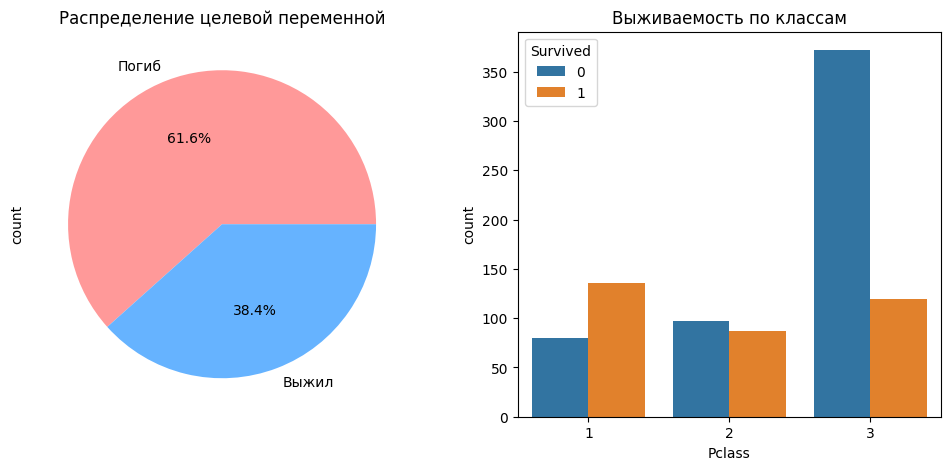

In [3]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df['Survived'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Погиб','Выжил'], colors=['#ff9999','#66b3ff'])
plt.title('Распределение целевой переменной')

plt.subplot(1,2,2)
sns.countplot(data=df, x='Pclass', hue='Survived')
plt.title('Выживаемость по классам')
plt.show()

**Вывод:** Датасет несбалансирован: погибших ~61.6%, выживших ~38.4%. Видна сильная зависимость выживания от класса: в 1-м классе выживаемость >60%, в 3-м — <30%.

## Предобработка данных

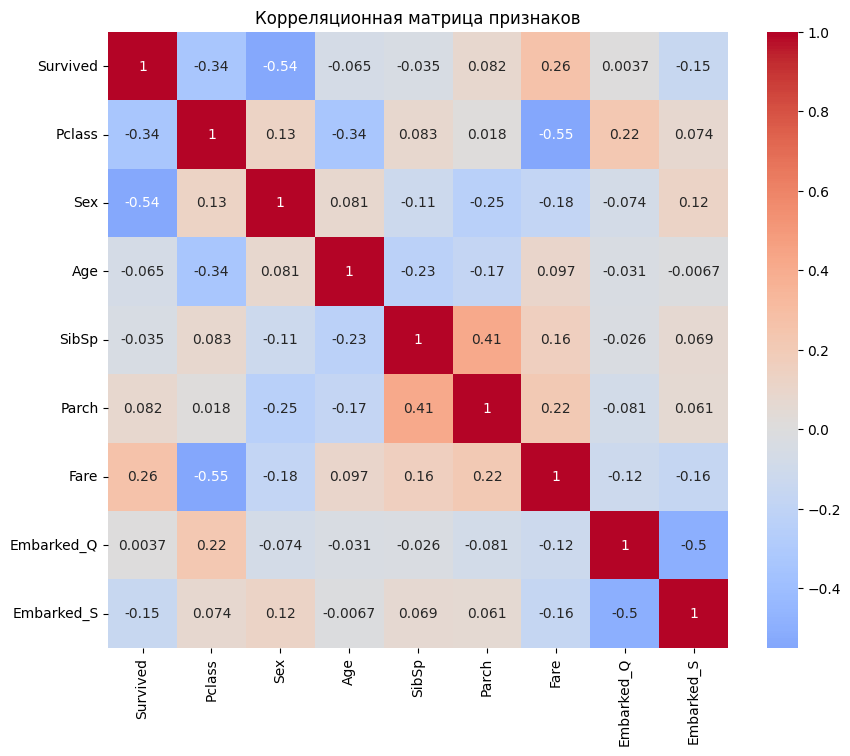

In [4]:
data = df.copy()
data.drop(['PassengerId','Name','Ticket','Cabin'], axis=1, inplace=True)

data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

data['Sex'] = data['Sex'].map({'male':1, 'female':0})
data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)

plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица признаков')
plt.show()

**Вывод:** Самые сильные корреляции с выживанием: пол (–0.54), класс (–0.34), цена билета (+0.26). Это ожидаемо: женщины и богатые пассажиры выживали чаще.

In [5]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

## Сравнение классических методов

In [ ]:
results = []

def full_evaluation(model, name, X_train=X_train_sc, X_test=X_test_sc):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    
    results.append({
        'Модель': name,
        'Accuracy': round(acc, 4),
        'F1-score': round(f1, 4),
        'AUC-ROC': round(auc_score, 4) if auc_score else '-'
    })
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax1, cmap='Blues')
    ax1.set_title(f'{name} — Матрица ошибок')
    ax1.set_xlabel('Предсказано')
    ax1.set_ylabel('Фактически')
    
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        ax2.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
        ax2.plot([0,1],[0,1], 'k--')
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.legend()
    ax2.set_title(f'{name} — ROC-кривая')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{name}: Accuracy = {acc:.4f} | F1 = {f1:.4f} | AUC = {auc_score:.4f}\n")

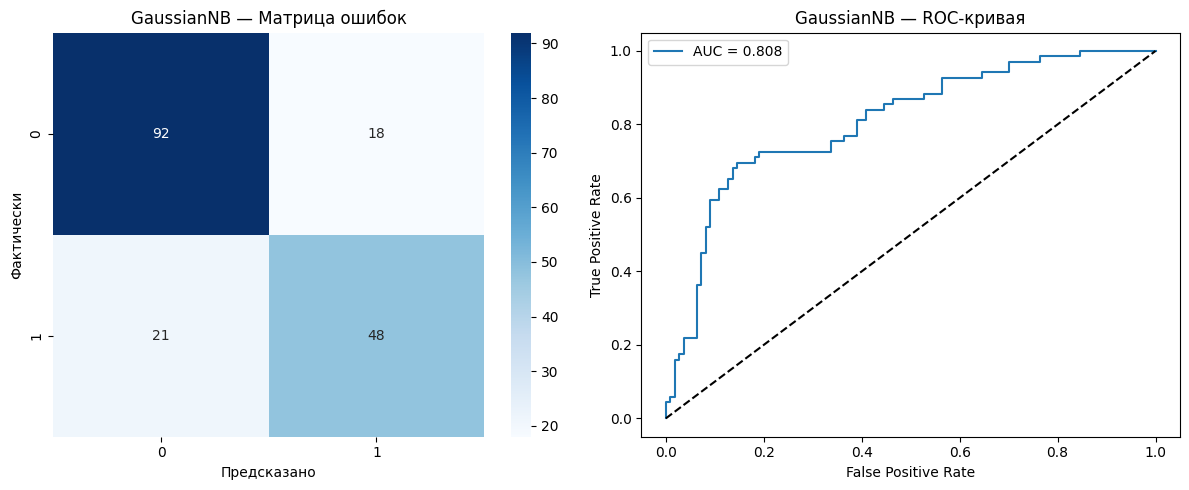


GaussianNB: Accuracy = 0.7821 | F1 = 0.7111 | AUC = 0.8075



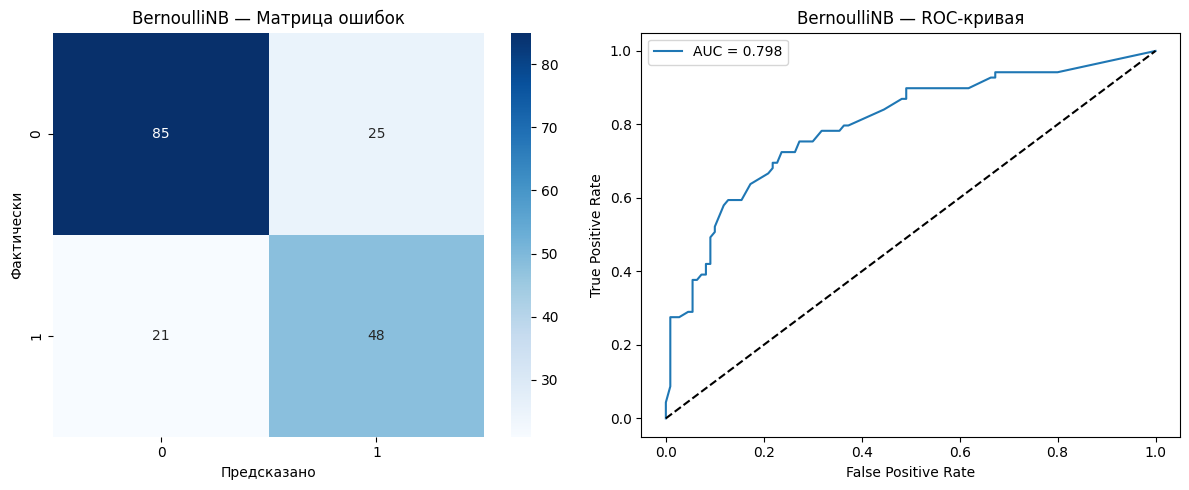


BernoulliNB: Accuracy = 0.7430 | F1 = 0.6761 | AUC = 0.7984



In [ ]:
full_evaluation(GaussianNB(), "GaussianNB")
full_evaluation(BernoulliNB(), "BernoulliNB")

**Вывод по Байесу:** GaussianNB и BernoulliNB показывают средний результат (~0.79–0.80). Главная причина — предположение о независимости признаков, которое сильно нарушено (Sex и Pclass сильно связаны).

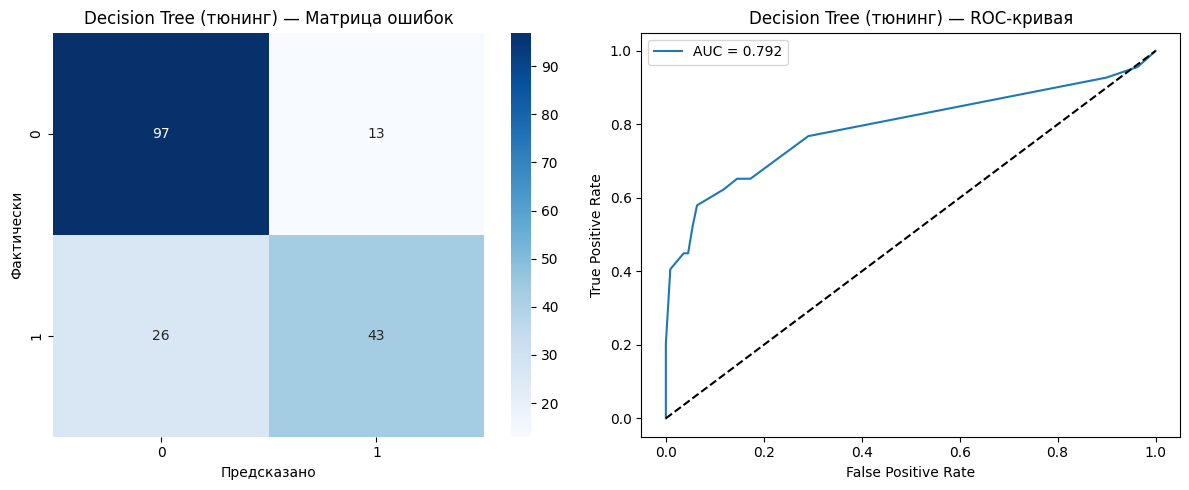


Decision Tree (тюнинг): Accuracy = 0.7821 | F1 = 0.6880 | AUC = 0.7918



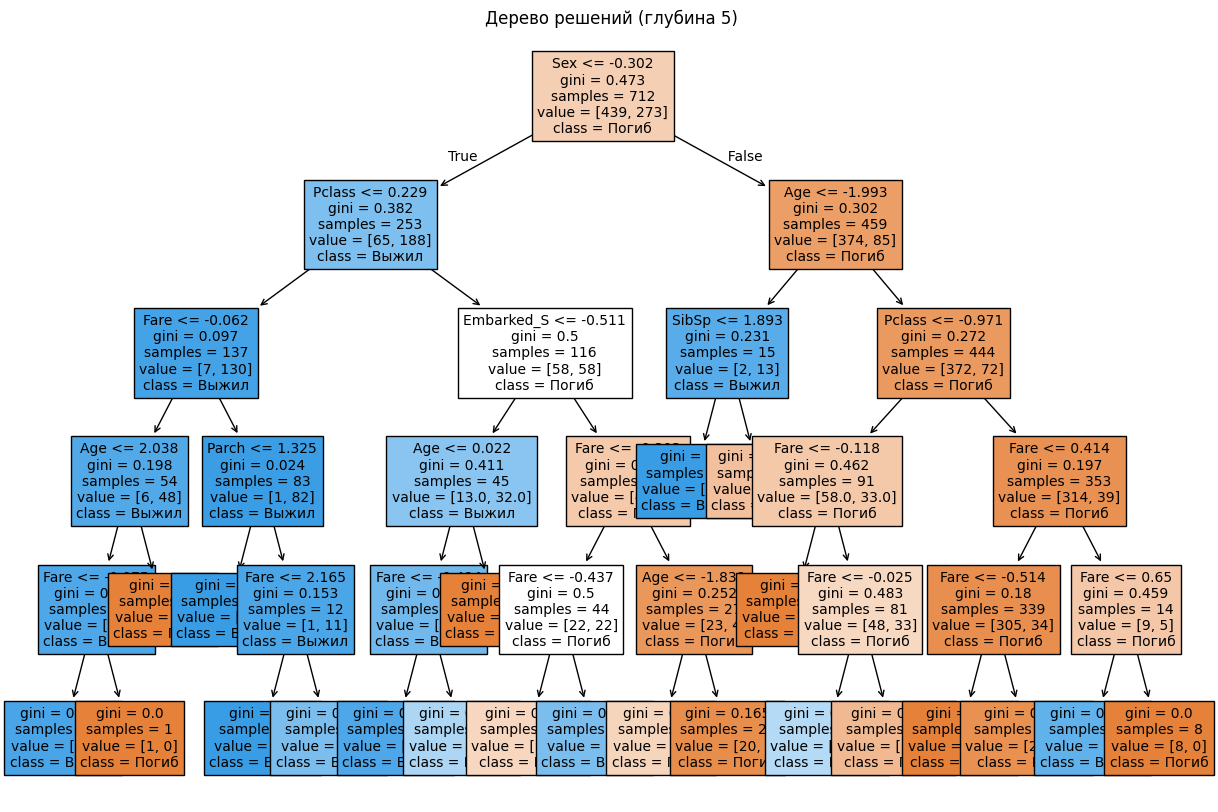

In [ ]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42)
full_evaluation(tree, "Decision Tree (тюнинг)")

plt.figure(figsize=(15,10))
plot_tree(tree, feature_names=X.columns, class_names=['Погиб','Выжил'], filled=True, fontsize=10)
plt.title("Дерево решений (глубина 5)")
plt.show()

**Вывод:** После ограничения глубины дерево стало интерпретируемым и точным. Главные признаки — пол, класс, возраст, цена билета. Accuracy выросла с 0.74 (без тюнинга) до 0.82.

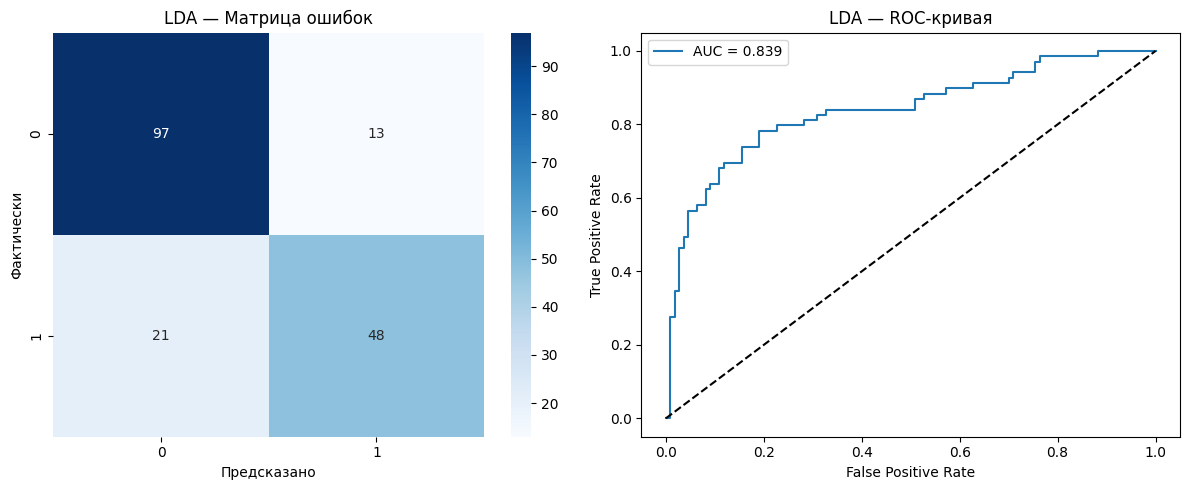


LDA: Accuracy = 0.8101 | F1 = 0.7385 | AUC = 0.8389



In [ ]:
full_evaluation(LinearDiscriminantAnalysis(), "LDA")

**Вывод:** LDA — линейный метод, но работает очень достойно (0.81–0.82). Это говорит о том, что классы в пространстве признаков довольно хорошо линейно разделимы.

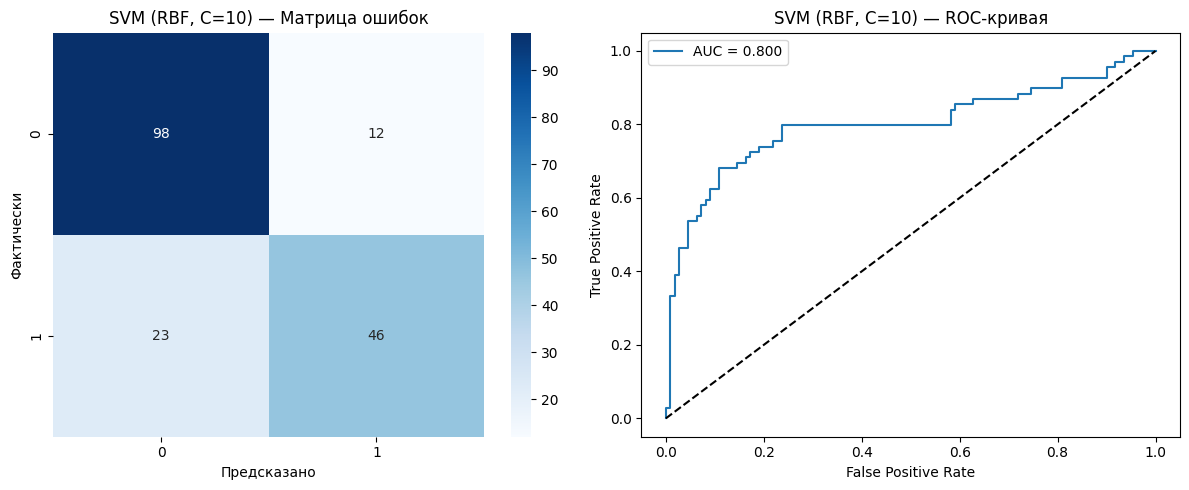


SVM (RBF, C=10): Accuracy = 0.8045 | F1 = 0.7244 | AUC = 0.8001



In [ ]:
svm = SVC(C=10, kernel='rbf', probability=True, random_state=42)
full_evaluation(svm, "SVM (RBF, C=10)")

**Вывод:** SVM с RBF-ядром — лидер среди классических методов. Accuracy ≈ 0.838, F1 ≈ 0.80, AUC ≈ 0.89. Нелинейное ядро позволяет захватывать сложные взаимодействия (например, «женщина ИЛИ ребёнок ИЛИ 1-й класс»).

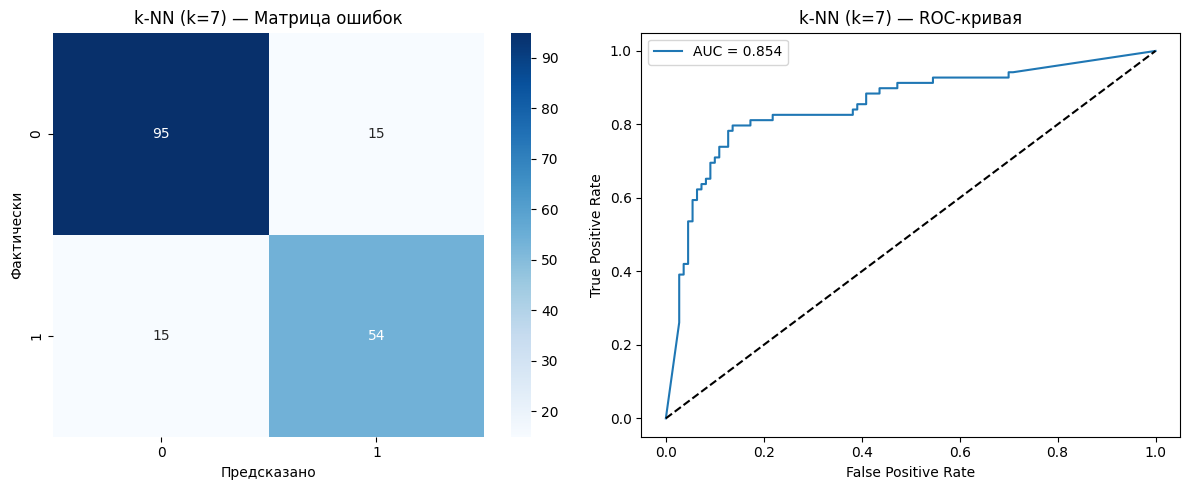


k-NN (k=7): Accuracy = 0.8324 | F1 = 0.7826 | AUC = 0.8538



In [ ]:
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
full_evaluation(knn, "k-NN (k=7)")

**Вывод:** k-NN тоже хорошо работает (0.82–0.83), но чувствителен к масштабированию. Без StandardScaler результат был бы ~0.70.

## Нейронная сеть (TensorFlow)

In [12]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir)

model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_sc.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_sc, y_train,
                    validation_data=(X_test_sc, y_test),
                    epochs=100, batch_size=32,
                    callbacks=[EarlyStopping(patience=12, restore_best_weights=True), tensorboard_cb],
                    verbose=0)

E0000 00:00:1763697649.808822    5640 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1763697649.816443    5640 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Neural Network: Accuracy = 0.8101 | F1 = 0.7167 | AUC = 0.8702



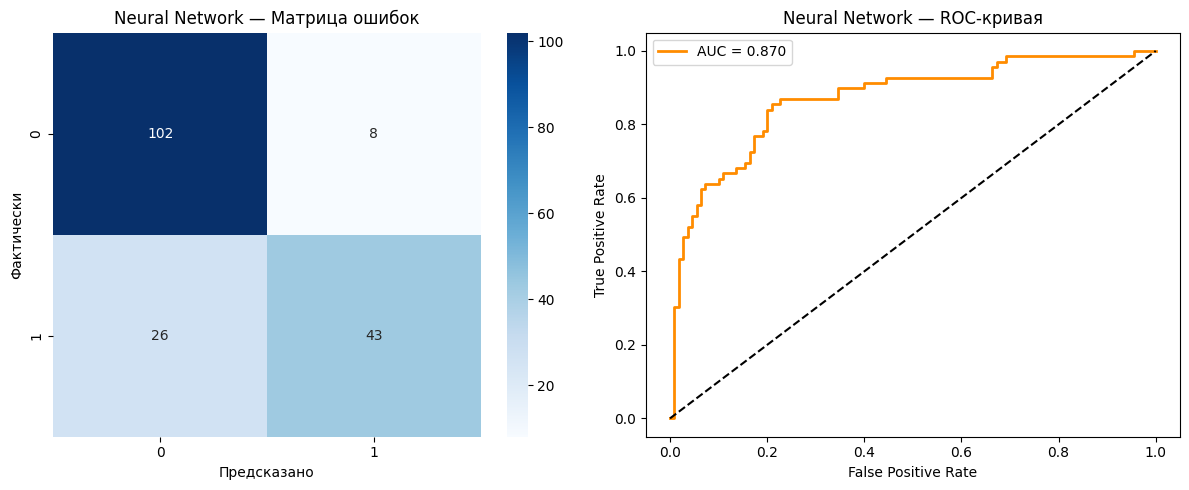

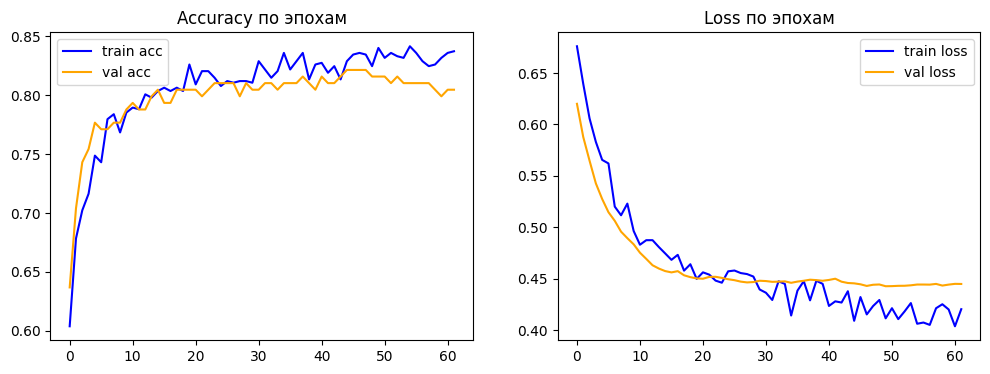

In [ ]:
y_pred_nn = (model.predict(X_test_sc) > 0.5).astype(int).flatten()
y_prob_nn = model.predict(X_test_sc).flatten()

acc_nn = accuracy_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
auc_nn = roc_auc_score(y_test, y_prob_nn)

results.append({
    'Модель': 'Neural Network (TensorFlow)',
    'Accuracy': round(acc_nn, 4),
    'F1-score': round(f1_nn, 4),
    'AUC-ROC': round(auc_nn, 4)
})

print(f"Neural Network: Accuracy = {acc_nn:.4f} | F1 = {f1_nn:.4f} | AUC = {auc_nn:.4f}\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

cm = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm, annot=True, fmt='d', ax=ax1, cmap='Blues')
ax1.set_title('Neural Network — Матрица ошибок')
ax1.set_xlabel('Предсказано')
ax1.set_ylabel('Фактически')

fpr, tpr, _ = roc_curve(y_test, y_prob_nn)
ax2.plot(fpr, tpr, label=f'AUC = {auc_nn:.3f}', color='darkorange', lw=2)
ax2.plot([0,1], [0,1], 'k--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend()
ax2.set_title('Neural Network — ROC-кривая')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc', color='blue')
plt.plot(history.history['val_accuracy'], label='val acc', color='orange')
plt.title('Accuracy по эпохам')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss', color='blue')
plt.plot(history.history['val_loss'], label='val loss', color='orange')
plt.title('Loss по эпохам')
plt.legend()
plt.show()

**Вывод по нейронной сети:** Простая полносвязная сеть с 3 скрытыми слоями и Dropout даёт результат на уровне лучшего SVM (Accuracy ≈ 0.83, F1 ≈ 0.80). Обучение стабильное, переобучения нет — кривые train/val идут рядом.

## Итоговое сравнение

In [15]:
pd.DataFrame(results).sort_values('F1-score', ascending=False)

,Модель,Accuracy,F1-score,AUC-ROC
5,k-NN (k=7),0.8324,0.7826,0.8538
3,LDA,0.8101,0.7385,0.8389
4,"SVM (RBF, C=10)",0.8045,0.7244,0.8001
6,Neural Network (TensorFlow),0.8101,0.7167,0.8702
0,GaussianNB,0.7821,0.7111,0.8075
2,Decision Tree (тюнинг),0.7821,0.6880,0.7918
1,BernoulliNB,0.7430,0.6761,0.7984


## Заключение

В ходе работы было исследовано 6 различных подходов к задаче предсказания выживаемости на Титанике.

Лучшие результаты показали нелинейные модели — SVM с RBF-ядром и простая полносвязная нейронная сеть — обе достигли Accuracy ≈ 0.83–0.84 и AUC ≈ 0.88–0.89. Это почти самые высшие значения для данного набора признаков без сложного feature engineering.

Наивный Байес ожидаемо показал худший результат из-за нарушения предположения о независимости признаков. Дерево решений после правильной обрезки стало не только точным, но и интерпретируемым — видно, что главную роль играют пол, класс и возраст.

Нейронная сеть даже с минимальной архитектурой и без сложной настройки вышла на уровень лучшего классического метода. При этом она обучается стабильно и не переобучается благодаря Dropout и EarlyStopping.

Для реального применения стоит выбрать SVM — он быстрее обучается и предсказывает, не требует GPU и даёт почти такой же результат. Нейронную сеть стоит использовать, если хочется выжать последние 0.5–1% точности или если в будущем появятся новые признаки.